In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.facecolor'] = '#f8fdff'
plt.rcParams['font.size'] = 10
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])

# Загрузка данных
FILE_ID = "1_RF8CV2Ej1UKbFwhVzy3kx5Q41cvHS62_0Is_Yv5YUU"
file_url = f"https://docs.google.com/spreadsheets/d/{FILE_ID}/export?format=csv"
df = pd.read_csv(file_url)

print("Первый взгляд на данные:")
print(f"Размер датасета: {df.shape}")
print("\nПервые 5 строк:")
display(df.head().style.background_gradient(cmap='Blues'))

Первый взгляд на данные:
Размер датасета: (1000, 16)

Первые 5 строк:


,Unnamed: 0,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,sequences
0,0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.900000,6360.300000,"VAPOR DIFFUSION, HANGING DROP",nan,1.780000,30.890000,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.000000,1994.000000,nan
1,1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.250000,7939.350000,nan,nan,2.000000,38.450000,nan,nan,1995.000000,nan
2,2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.070000,18112.800000,nan,nan,3.090000,60.200000,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, PH 9.0",9.000000,1999.000000,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG
3,3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.200000,7637.170000,"VAPOR DIFFUSION, SITTING DROP",277.000000,2.280000,46.060000,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temperature 277.00K",7.000000,1995.000000,nan
4,4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.740000,18926.610000,nan,nan,2.750000,55.280000,nan,nan,1993.000000,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK


In [29]:
# ИНФОРМАЦИЯ О ДАННЫХ
print("ИНФОРМАЦИЯ О ДАТАСЕТЕ:")
print("="*50)
print(f"Количество записей: {df.shape[0]:,}")
print(f"Количество признаков: {df.shape[1]}")
print(f"Пропущенных значений: {df.isnull().sum().sum():,}")

print("\n Типы данных:")
print(df.dtypes)

print("\n Пропущенные значения:")
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = missing_pct[missing_pct > 0].reset_index()
missing_df.columns = ['Столбец', 'Доля_пропусков_%']
if len(missing_df) > 0:
    display(missing_df.style.format({'Доля_пропусков_%': '{:.1f}%'}).background_gradient(cmap='Reds'))

ИНФОРМАЦИЯ О ДАТАСЕТЕ:
Количество записей: 1,000
Количество признаков: 16
Пропущенных значений: 3,284

 Типы данных:
Unnamed: 0                    int64
structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
sequences                    object
dtype: object

 Пропущенные значения:


,Столбец,Доля_пропусков_%
0,macromoleculeType,3.7%
1,resolution,17.6%
2,crystallizationMethod,84.1%
3,crystallizationTempK,92.7%
4,densityMatthews,17.1%
5,densityPercentSol,17.1%
6,pdbxDetails,39.2%
7,phValue,41.3%
8,publicationYear,2.7%
9,sequences,12.9%


In [30]:
# СТАТИСТИЧЕСКИЙ АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ
print("СТАТИСТИКА ЧИСЛОВЫХ ПРИЗНАКОВ:")
numeric_cols = df.select_dtypes(include=['number']).columns
stats_summary = df[numeric_cols].describe().T
stats_summary['IQR'] = stats_summary['75%'] - stats_summary['25%']
stats_summary['CV'] = stats_summary['std'] / stats_summary['mean']  # Коэффициент вариации

display(stats_summary.style.background_gradient(cmap='Blues', axis=0))

СТАТИСТИКА ЧИСЛОВЫХ ПРИЗНАКОВ:


,count,mean,std,min,25%,50%,75%,max,IQR,CV
Unnamed: 0,1000.000000,499.500000,288.819436,0.000000,249.750000,499.500000,749.250000,999.000000,499.500000,0.578217
residueCount,1000.000000,345.308000,470.835484,0.000000,95.750000,218.500000,418.250000,5808.000000,322.500000,1.363523
resolution,824.000000,2.143689,0.424913,0.860000,1.850000,2.100000,2.400000,3.700000,0.550000,0.198216
structureMolecularWeight,1000.000000,41555.027430,53264.561853,853.920000,13963.417500,25783.005000,48726.055000,645639.620000,34762.637500,1.281784
crystallizationTempK,73.000000,281.821918,7.126033,277.000000,277.000000,277.000000,289.000000,295.500000,12.000000,0.025286
densityMatthews,829.000000,2.637479,0.537638,1.500000,2.290000,2.530000,2.880000,5.490000,0.590000,0.203846
densityPercentSol,829.000000,51.043378,9.207266,18.000000,45.130000,50.990000,56.950000,77.580000,11.820000,0.180381
phValue,587.000000,6.702692,1.135462,3.600000,6.000000,6.800000,7.500000,9.000000,1.500000,0.169404
publicationYear,973.000000,1996.097636,2.974121,1974.000000,1995.000000,1997.000000,1998.000000,2003.000000,3.000000,0.001490


In [49]:
# ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ И ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ

# Создаем копию для преобразований
df_clean = df.copy()

# Анализ уникальных значений в категориальных столбцах
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_vals = df_clean[col].unique()

# Преобразование категориальных переменных
# Пример для бинарных переменных:
binary_mappings = {}
for col in categorical_cols:
    if df_clean[col].nunique() == 2:
        mapping = {val: i for i, val in enumerate(df_clean[col].unique())}
        binary_mappings[col] = mapping
        df_clean[col] = df_clean[col].map(mapping)
        print(f"Преобразовано {col}: {mapping}")

АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ: structureMolecularWeight
Статистика structureMolecularWeight:
Среднее: 41555.03
Медиана: 25783.01
Стандартное отклонение: 53264.56


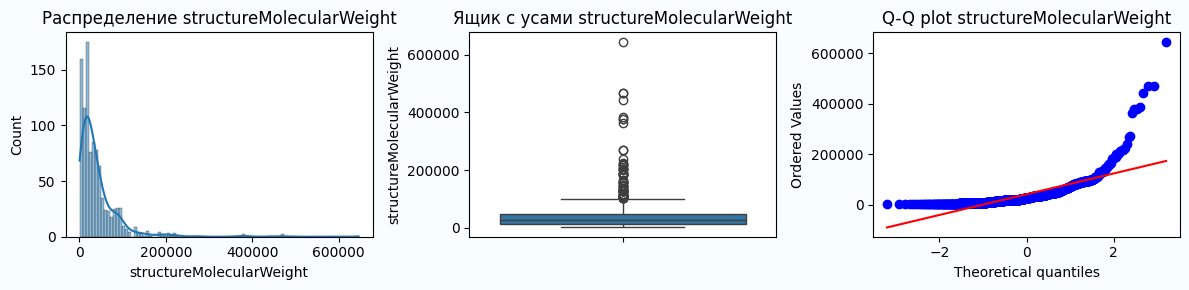

In [32]:
    # АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
# structureMolecularWeight - целевая переменная
target_col = df_clean.columns[7]
print(f"АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ: {target_col}")
print("="*50)

    print(f"Статистика {target_col}:")
    print(f"Среднее: {df_clean[target_col].mean():.2f}")
    print(f"Медиана: {df_clean[target_col].median():.2f}")
    print(f"Стандартное отклонение: {df_clean[target_col].std():.2f}")

    plt.figure(figsize=(12, 3))

    plt.subplot(1, 3, 1)
    sns.histplot(data=df_clean, x=target_col, kde=True)
    plt.title(f'Распределение {target_col}')

    plt.subplot(1, 3, 2)
    sns.boxplot(data=df_clean, y=target_col)
    plt.title(f'Ящик с усами {target_col}')

    plt.subplot(1, 3, 3)
    stats.probplot(df_clean[target_col].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q plot {target_col}')

    plt.tight_layout()
    plt.show()

РАСПРЕДЕЛЕНИЯ ЧИСЛОВЫХ ПРИЗНАКОВ:


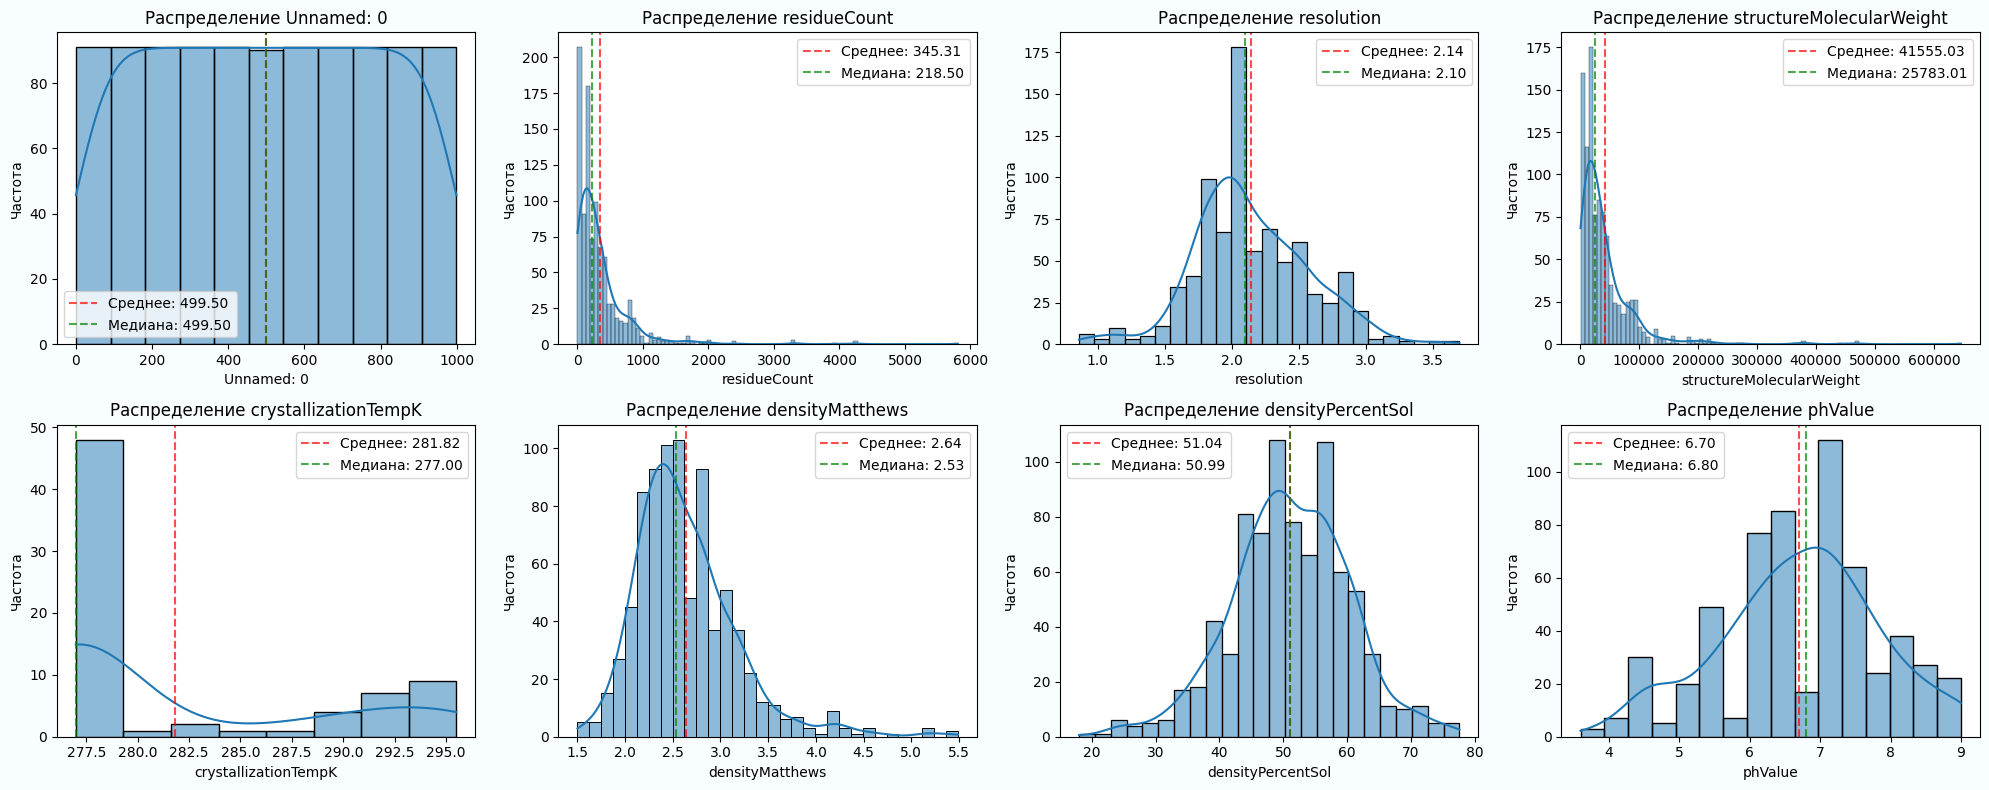


 ОСНОВНЫЕ СТАТИСТИКИ ЧИСЛОВЫХ ПРИЗНАКОВ:
Unnamed: 0: асимметрия = 0.00, эксцесс = -1.20
residueCount: асимметрия = 4.73, эксцесс = 35.46
resolution: асимметрия = 0.24, эксцесс = 0.55
structureMolecularWeight: асимметрия = 4.70, эксцесс = 33.93
crystallizationTempK: асимметрия = 0.97, эксцесс = -0.86
densityMatthews: асимметрия = 1.45, эксцесс = 3.96
densityPercentSol: асимметрия = -0.17, эксцесс = 0.41
phValue: асимметрия = -0.20, эксцесс = -0.27
publicationYear: асимметрия = -2.52, эксцесс = 12.54


In [34]:
# ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ ЧИСЛОВЫХ ПРИЗНАКОВ
print("РАСПРЕДЕЛЕНИЯ ЧИСЛОВЫХ ПРИЗНАКОВ:")
numeric_cols = df_clean.select_dtypes(include=['number']).columns

# Ограничим количество графиков для читаемости
plot_cols = numeric_cols[:8]  # Первые 8 числовых признаков

n_rows = (len(plot_cols) + 3) // 4  # Округление вверх
fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    if i < len(plot_cols):
        # Гистограмма с KDE
        sns.histplot(data=df_clean, x=col, kde=True, ax=axes[i])
        axes[i].set_title(f'Распределение {col}', fontsize=12)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Частота')

        # Добавим статистики на график
        mean_val = df_clean[col].mean()
        median_val = df_clean[col].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Среднее: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Медиана: {median_val:.2f}')
        axes[i].legend()
    else:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Вывод статистик для всех числовых признаков
print("\n ОСНОВНЫЕ СТАТИСТИКИ ЧИСЛОВЫХ ПРИЗНАКОВ:")
for col in numeric_cols:
    skewness = stats.skew(df_clean[col].dropna())
    kurtosis = stats.kurtosis(df_clean[col].dropna())
    print(f"{col}: асимметрия = {skewness:.2f}, эксцесс = {kurtosis:.2f}")

АНАЛИЗ ВЫБРОСОВ:


,Признак,Выбросы,Доля_выбросов_%,Нижняя_граница,Верхняя_граница
0,Unnamed: 0,0,0.000000,-499.500000,1498.500000
1,residueCount,59,5.900000,-388.000000,902.000000
2,resolution,14,1.400000,1.025000,3.225000
3,structureMolecularWeight,65,6.500000,-38180.538750,100870.011250
4,crystallizationTempK,0,0.000000,259.000000,307.000000
5,densityMatthews,31,3.100000,1.405000,3.765000
6,densityPercentSol,16,1.600000,27.400000,74.680000
7,phValue,1,0.100000,3.750000,9.750000
8,publicationYear,28,2.800000,1990.500000,2002.500000


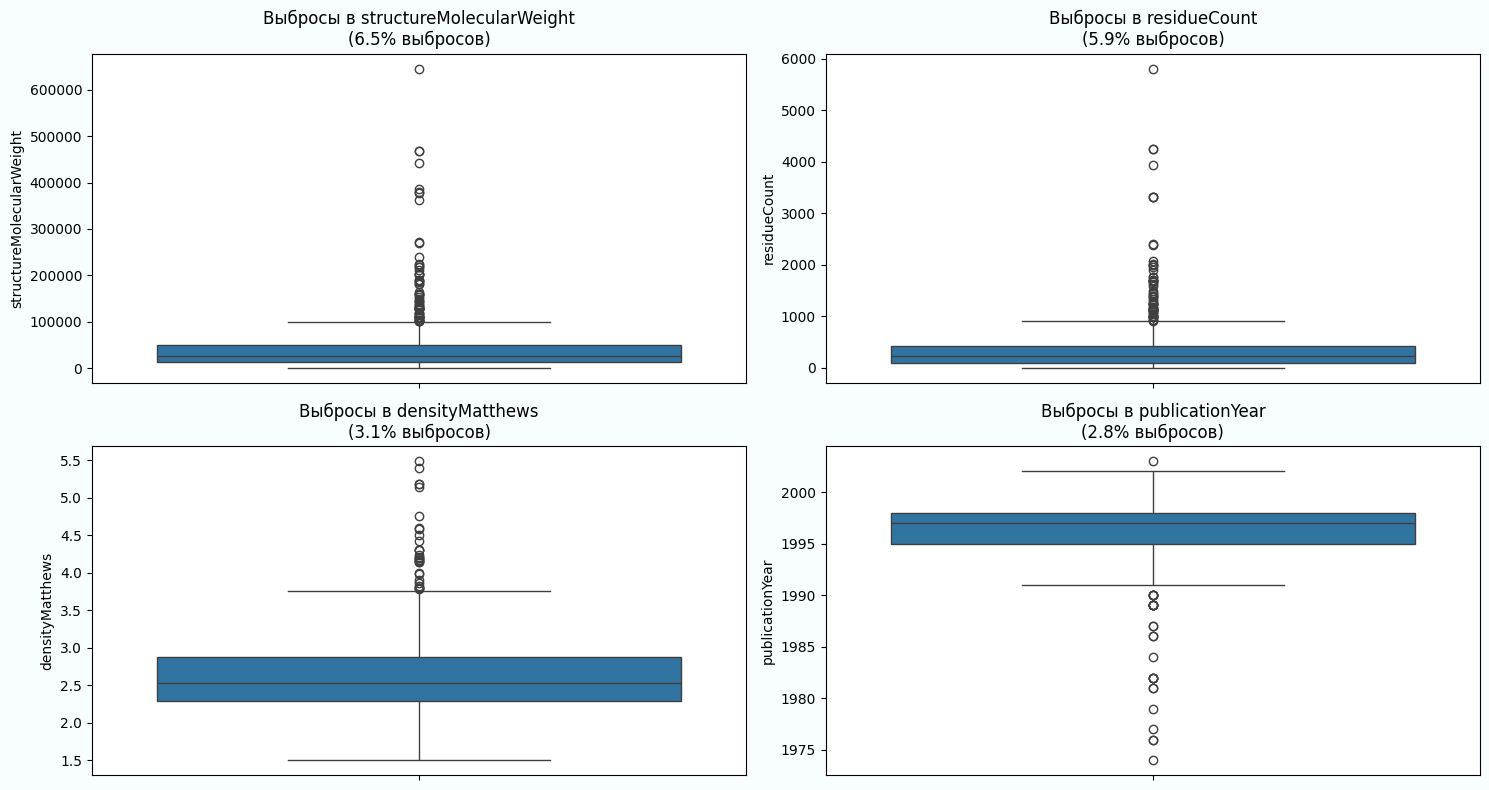

In [35]:
# ПОИСК ВЫБРОСОВ
print("АНАЛИЗ ВЫБРОСОВ:")
print("="*50)

outliers_summary = []
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    outliers_pct = (outliers / len(df_clean)) * 100

    outliers_summary.append({
        'Признак': col,
        'Выбросы': outliers,
        'Доля_выбросов_%': outliers_pct,
        'Нижняя_граница': lower_bound,
        'Верхняя_граница': upper_bound
    })

outliers_df = pd.DataFrame(outliers_summary)
display(outliers_df.style.background_gradient(cmap='Reds', subset=['Доля_выбросов_%']))

# Визуализация выбросов для признаков с наибольшим количеством выбросов
top_outliers = outliers_df.nlargest(4, 'Доля_выбросов_%')['Признак'].tolist()

if top_outliers:
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    axes = axes.flatten()

    for i, col in enumerate(top_outliers):
        if i < 4:
            sns.boxplot(data=df_clean, y=col, ax=axes[i])
            axes[i].set_title(f'Выбросы в {col}\n({outliers_df[outliers_df["Признак"]==col]["Доля_выбросов_%"].values[0]:.1f}% выбросов)')

    plt.tight_layout()
    plt.show()

МАТРИЦА КОРРЕЛЯЦИЙ:


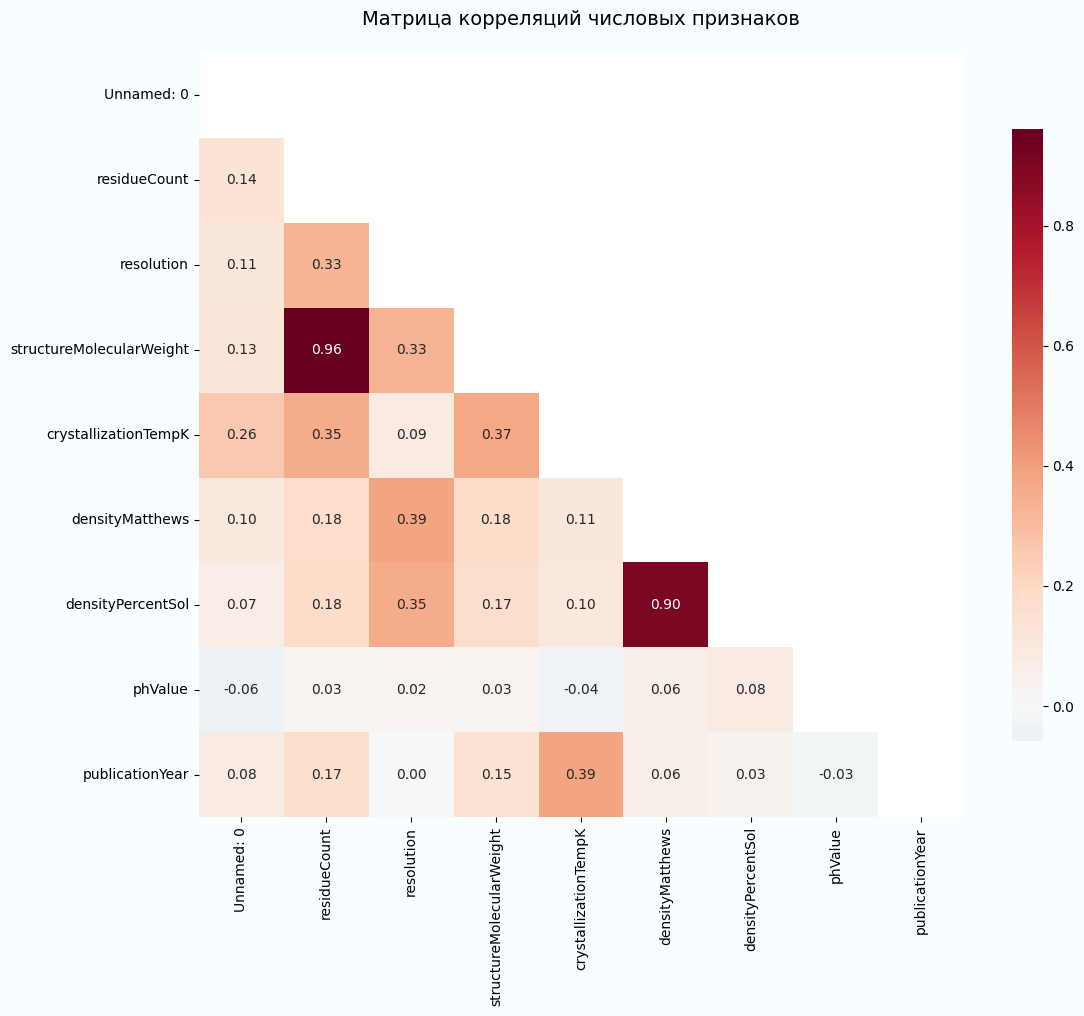


ВЫСОКИЕ КОРРЕЛЯЦИИ (|r| > 0.7):


,Признак1,Признак2,Корреляция
0,residueCount,structureMolecularWeight,0.960801
1,densityMatthews,densityPercentSol,0.899523


In [42]:
# МАТРИЦА КОРРЕЛЯЦИЙ
print("МАТРИЦА КОРРЕЛЯЦИЙ:")
print("="*50)

# Вычисляем корреляционную матрицу
corr_matrix = df_clean.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций числовых признаков', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Анализ высоких корреляций
print("\nВЫСОКИЕ КОРРЕЛЯЦИИ (|r| > 0.7):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Признак1', 'Признак2', 'Корреляция'])
    display(high_corr_df.sort_values('Корреляция', key=abs, ascending=False))

ВЗАИМОСВЯЗИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (structureMolecularWeight):
Корреляции с целевой переменной:


,structureMolecularWeight
residueCount,0.960801
crystallizationTempK,0.368721
resolution,0.333912
densityMatthews,0.184183
densityPercentSol,0.168686
publicationYear,0.152482
Unnamed: 0,0.128245
phValue,0.028140


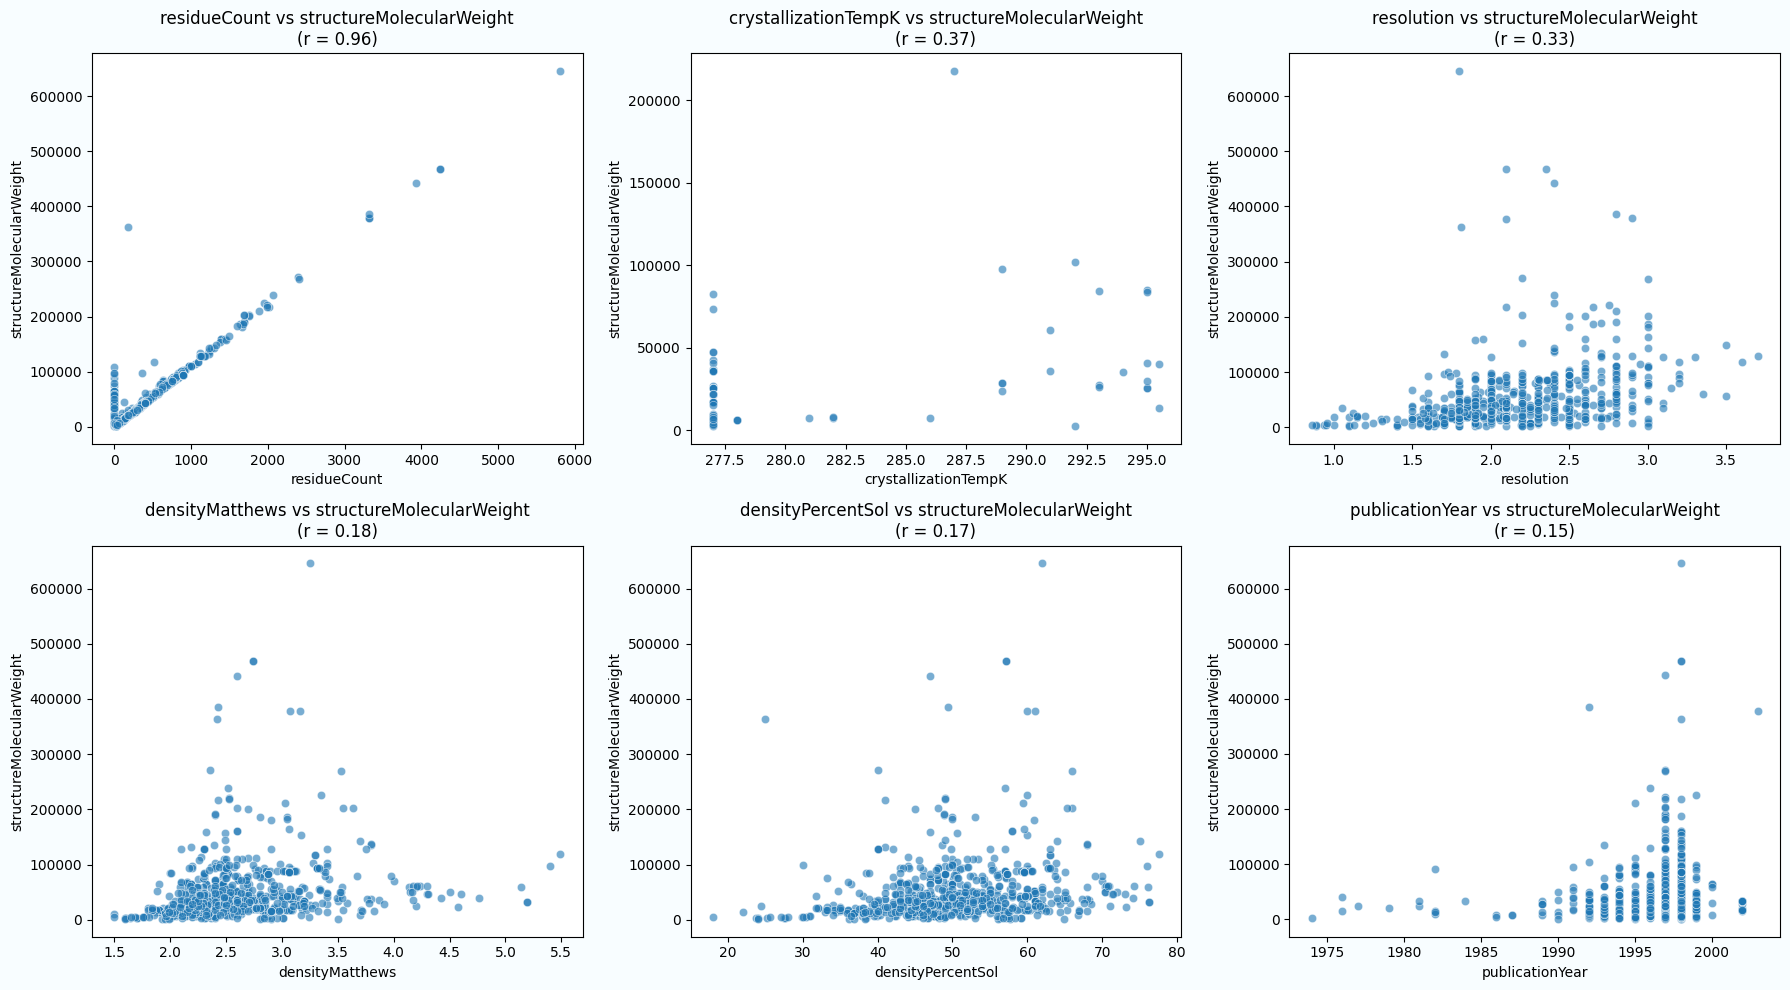

In [43]:
# АНАЛИЗ ВЗАИМОСВЯЗЕЙ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
if target_col in df_clean.columns:
    print(f"ВЗАИМОСВЯЗИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ({target_col}):")
    print("="*50)

    # Корреляции с целевой переменной
    if df_clean[target_col].dtype in ['int64', 'float64']:
        target_correlations = target_correlations[target_correlations.index != target_col]

        print("Корреляции с целевой переменной:")
        display(pd.DataFrame(target_correlations).style.background_gradient(cmap='RdBu_r', axis=0))

        # Визуализация топ корреляций
        top_corr_features = target_correlations.head(6).index

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        for i, feature in enumerate(top_corr_features):
            if i < 6:
                sns.scatterplot(data=df_clean, x=feature, y=target_col, alpha=0.6, ax=axes[i])
                axes[i].set_title(f'{feature} vs {target_col}\n(r = {target_correlations[feature]:.2f})')

        plt.tight_layout()
        plt.show()

    else:
        # Для категориальной целевой переменной
        print("Анализ для категориальной целевой переменной:")

        # Сравнение распределений числовых признаков по категориям целевой переменной
        top_features = numeric_cols[:6]  # Первые 6 числовых признаков

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        for i, feature in enumerate(top_features):
            if i < 6:
                sns.boxplot(data=df_clean, x=target_col, y=feature, ax=axes[i])
                axes[i].set_title(f'{feature} по {target_col}')
                axes[i].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

In [44]:
# АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ (VIF)
print("АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ (VIF):")
print("="*50)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(df, features):
    """Вычисляет VIF для набора признаков"""
    X = df[features].dropna()
    X = add_constant(X)

    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i+1) for i in range(len(features))]

    return vif_data

# Выбираем только числовые признаки для VIF (исключаем целевую)
features_for_vif = [col for col in numeric_cols if col != target_col]

if len(features_for_vif) > 1:
    try:
        vif_df = calculate_vif(df_clean, features_for_vif)
        print("VIF факторы (мультиколлинеарность):")
        display(vif_df.sort_values('VIF', ascending=False).style.background_gradient(cmap='Reds', subset=['VIF']))

        # Интерпретация VIF
        print("\nИНТЕРПРЕТАЦИЯ VIF:")
        print("VIF < 5: Нет мультиколлинеарности")
        print("5 ≤ VIF < 10: Умеренная мультиколлинеарность")
        print("VIF ≥ 10: Высокая мультиколлинеарность")

        high_vif = vif_df[vif_df['VIF'] >= 5]
        if len(high_vif) > 0:
            print(f"\n Обнаружены признаки с высокой мультиколлинеарностью:")
            print(high_vif[['Feature', 'VIF']])
        else:
            print("Мультиколлинеарность в пределах нормы")

    except Exception as e:
        print(f"Ошибка при вычислении VIF: {e}")
else:
    print("Недостаточно признаков для анализа VIF")

АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ (VIF):
VIF факторы (мультиколлинеарность):


,Feature,VIF
5,densityPercentSol,2.961770
4,densityMatthews,2.821355
7,publicationYear,1.555590
0,Unnamed: 0,1.509661
1,residueCount,1.382500
2,resolution,1.259824
3,crystallizationTempK,1.223901
6,phValue,1.178011



ИНТЕРПРЕТАЦИЯ VIF:
VIF < 5: Нет мультиколлинеарности
5 ≤ VIF < 10: Умеренная мультиколлинеарность
VIF ≥ 10: Высокая мультиколлинеарность
Мультиколлинеарность в пределах нормы


In [45]:
# СВОДНЫЙ ОТЧЕТ О КАЧЕСТВЕ ДАННЫХ
print("СВОДНЫЙ ОТЧЕТ О КАЧЕСТВЕ ДАННЫХ:")
print("="*50)

def create_data_quality_report(df):
    report_data = []

    for col in df.columns:
        col_data = {
            'Столбец': col,
            'Тип_данных': df[col].dtype,
            'Уникальных_значений': df[col].nunique(),
            'Пропущенных': df[col].isnull().sum(),
            'Доля_пропусков_%': (df[col].isnull().sum() / len(df)) * 100
        }

        if df[col].dtype in ['int64', 'float64']:
            col_data.update({
                'Среднее': df[col].mean(),
                'Медиана': df[col].median(),
                'Стд_отклонение': df[col].std(),
                'Минимум': df[col].min(),
                'Максимум': df[col].max()
            })
        else:
            # Для категориальных переменных
            col_data.update({
                'Самый_частый': df[col].mode().iloc[0] if len(df[col].mode()) > 0 else 'N/A',
                'Частота_моды_%': (df[col].value_counts().iloc[0] / len(df)) * 100 if len(df[col].value_counts()) > 0 else 0
            })

        report_data.append(col_data)

    return pd.DataFrame(report_data)

quality_report = create_data_quality_report(df_clean)

# Стилизация отчета
styled_report = quality_report.style.format({
    'Доля_пропусков_%': '{:.1f}%',
    'Среднее': '{:.2f}',
    'Медиана': '{:.2f}',
    'Стд_отклонение': '{:.2f}',
    'Частота_моды_%': '{:.1f}%'
}).background_gradient(cmap='Blues', subset=['Доля_пропусков_%'])

display(styled_report)

СВОДНЫЙ ОТЧЕТ О КАЧЕСТВЕ ДАННЫХ:


,Столбец,Тип_данных,Уникальных_значений,Пропущенных,Доля_пропусков_%,Среднее,Медиана,Стд_отклонение,Минимум,Максимум,Самый_частый,Частота_моды_%
0,Unnamed: 0,int64,1000,0,0.0%,499.50,499.50,288.82,0.000000,999.000000,nan,nan%
1,structureId,object,1000,0,0.0%,nan,nan,nan,nan,nan,"1,20E+09",0.1%
2,classification,object,284,0,0.0%,nan,nan,nan,nan,nan,DNA,10.6%
3,experimentalTechnique,object,3,0,0.0%,nan,nan,nan,nan,nan,X-RAY DIFFRACTION,83.2%
4,macromoleculeType,object,8,37,3.7%,nan,nan,nan,nan,nan,Protein,80.1%
5,residueCount,int64,395,0,0.0%,345.31,218.50,470.84,0.000000,5808.000000,nan,nan%
6,resolution,float64,104,176,17.6%,2.14,2.10,0.42,0.860000,3.700000,nan,nan%
7,structureMolecularWeight,float64,928,0,0.0%,41555.03,25783.01,53264.56,853.920000,645639.620000,nan,nan%
8,crystallizationMethod,object,20,841,84.1%,nan,nan,nan,nan,nan,"VAPOR DIFFUSION, HANGING DROP",4.3%
9,crystallizationTempK,float64,13,927,92.7%,281.82,277.00,7.13,277.000000,295.500000,nan,nan%


In [46]:
 # РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ ДАННЫХ
print("РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ ДАННЫХ:")
print("="*50)

recommendations = []

# 1. Анализ пропущенных значений
missing_cols = quality_report[quality_report['Пропущенных'] > 0]['Столбец'].tolist()
if missing_cols:
    recommendations.append(f"ОБРАБОТКА ПРОПУСКОВ: Заполнить пропуски в {len(missing_cols)} столбцах")
    for col in missing_cols[:3]:  # Покажем первые 3
        missing_pct = quality_report[quality_report['Столбец'] == col]['Доля_пропусков_%'].values[0]
        recommendations.append(f"   - {col}: {missing_pct:.1f}% пропусков")

# 2. Анализ выбросов
high_outliers = outliers_df[outliers_df['Доля_выбросов_%'] > 5]['Признак'].tolist()
if high_outliers:
    recommendations.append(f"ВЫБРОСЫ: Обработать выбросы в {len(high_outliers)} признаках")
    for col in high_outliers[:3]:
        outlier_pct = outliers_df[outliers_df['Признак'] == col]['Доля_выбросов_%'].values[0]
        recommendations.append(f"   - {col}: {outlier_pct:.1f}% выбросов")

# 3. Анализ мультиколлинеарности
if 'vif_df' in locals():
    high_vif = vif_df[vif_df['VIF'] >= 5]['Feature'].tolist()
    if high_vif:
        recommendations.append(f"МУЛЬТИКОЛЛИНЕАРНОСТЬ: Рассмотреть удаление {len(high_vif)} признаков")
        for col in high_vif[:3]:
            vif_val = vif_df[vif_df['Feature'] == col]['VIF'].values[0]
            recommendations.append(f"   - {col}: VIF = {vif_val:.1f}")

# 4. Преобразование категориальных переменных
remaining_categorical = df_clean.select_dtypes(include=['object']).columns.tolist()
if remaining_categorical:
    recommendations.append(f"КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ: Преобразовать {len(remaining_categorical)} признаков")
    for col in remaining_categorical[:3]:
        recommendations.append(f"   - {col}: {df_clean[col].nunique()} уникальных значений")

# 5. Масштабирование признаков
numeric_for_scaling = [col for col in numeric_cols if col != target_col]
if numeric_for_scaling:
    recommendations.append(f"МАСШТАБИРОВАНИЕ: Масштабировать {len(numeric_for_scaling)} числовых признаков")

# Вывод рекомендаций
if recommendations:
    print("На основе анализа рекомендую:")
    for rec in recommendations:
        print(rec)
else:
    print("Данные в хорошем состоянии! Минимальная предобработка требуется.")

print(f"\nОБЩАЯ СТАТИСТИКА:")
print(f"• Всего записей: {len(df_clean):,}")
print(f"• Всего признаков: {len(df_clean.columns)}")
print(f"• Числовых признаков: {len(numeric_cols)}")
print(f"• Категориальных признаков: {len(df_clean.select_dtypes(include=['object']).columns)}")

РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ ДАННЫХ:
На основе анализа рекомендую:
ОБРАБОТКА ПРОПУСКОВ: Заполнить пропуски в 10 столбцах
   - macromoleculeType: 3.7% пропусков
   - resolution: 17.6% пропусков
   - crystallizationMethod: 84.1% пропусков
ВЫБРОСЫ: Обработать выбросы в 2 признаках
   - residueCount: 5.9% выбросов
   - structureMolecularWeight: 6.5% выбросов
КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ: Преобразовать 7 признаков
   - structureId: 1000 уникальных значений
   - classification: 284 уникальных значений
   - experimentalTechnique: 3 уникальных значений
МАСШТАБИРОВАНИЕ: Масштабировать 8 числовых признаков

ОБЩАЯ СТАТИСТИКА:
• Всего записей: 1,000
• Всего признаков: 16
• Числовых признаков: 9
• Категориальных признаков: 7
